# OCR Baseline using LPRNet (PyTorch)

This notebook implements the OCR pipeline using **LPRNet**, a lightweight Convolutional Neural Network designed for License Plate Recognition.

**Optimized for A100 GPU:**
- **Batch Size**: 1024
- **Mixed Precision**: Enabled (AMP)
- **Workers**: 8
- **Progress Tracking**: TQDM enabled
- **Metrics**: Sequence Acc, Char Acc, Edit Distance

**Steps:**
1. **Setup**: Import libraries and Modules.
2. **Data**: Load dataset using custom `LPRDataset`.
3. **Model**: Initialize `LPRNet`.
4. **Training**: Train the model using CTC Loss with AMP.
5. **Inference**: Evaluate on validation set.

## 1. Setup

In [50]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler # Mixed Precision
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# Add src to path if needed
sys.path.append('..')

from src.ocr.lprnet import build_lprnet
from src.ocr.reader import LPRDataset, collate_fn
from src.ocr.decoder import LPRLabelEncoder, CHARS
from src.evaluation.metrics import compute_ocr_metrics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check CUDA Capability
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.20 GB


## 2. Dataset Preparation

In [51]:
DATASET_DIR = "../datasets/plate_text_cropped"
IMAGES_DIR = os.path.join(DATASET_DIR, "dataset")
LABEL_FILE = os.path.join(DATASET_DIR, "label.csv")

# HPC Optimization
BATCH_SIZE = 32 # Increased for A100
NUM_WORKERS = 8   # Parallel data loading
PIN_MEMORY = True # Speed up host-to-device transfer

IMG_SIZE = (94, 24) # LPRNet standard input size

# Initialize Dataset
dataset = LPRDataset(img_dir=IMAGES_DIR, label_file=LABEL_FILE, img_size=IMG_SIZE)

# Split Dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

Train samples: 1490, Val samples: 373


## 3. Model Initialization

In [52]:
lpr_max_len = 18 # Maximum length of license plate
class_num = len(CHARS) + 1 # +1 for blank

model = build_lprnet(lpr_max_len=lpr_max_len, class_num=class_num, dropout_rate=0.5)
model.to(device)
# print(model) # Commented out to reduce log clutter

LPRNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (4): SmallBasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (3): ReLU()
        (4): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (5): ReLU()
        (6): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool3d(kernel_size=(1, 3, 3), stride=(2, 1, 2), padding=0, dilation=1, ceil_mode=False)
    (8): SmallBasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kern

## 4. Training Loop (with AMP & TQDM)

In [53]:
criterion = nn.CTCLoss(blank=len(CHARS), reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
scaler = GradScaler() # For Mixed Precision

num_epochs = 100

def train(model, loader, optimizer, criterion, device, scaler, epoch):
    model.train()
    epoch_loss = 0
    pbar = tqdm(loader, desc=f"Train Epoch {epoch+1}", leave=False)
    
    for images, labels, lengths in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        with autocast():
            logits = model(images)
            log_probs = logits.permute(2, 0, 1)
            log_probs = log_probs.log_softmax(2)
            input_lengths = torch.full(size=(images.size(0),), fill_value=logits.size(2), dtype=torch.long)
            loss = criterion(log_probs, labels, input_lengths, lengths)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
    return epoch_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    encoder = LPRLabelEncoder(CHARS)
    
    all_preds = []
    all_targets = []
    
    pbar = tqdm(loader, desc="Evaluating", leave=False)
    
    with torch.no_grad():
        for images, labels, lengths in pbar:
            images = images.to(device, non_blocking=True)
            
            with autocast():
                logits = model(images)
                
            preds = encoder.decode_greedy(logits)
            
            start_idx = 0
            label_list = labels.cpu().numpy()
            for i, length in enumerate(lengths):
                true_indices = label_list[start_idx : start_idx + length]
                true_text = "".join([CHARS[idx] for idx in true_indices])
                start_idx += length
                
                all_preds.append(preds[i])
                all_targets.append(true_text)
                
    metrics = compute_ocr_metrics(all_preds, all_targets)
    return metrics

# Start Training
print("Starting training...")
for epoch in range(num_epochs):
    loss = train(model, train_loader, optimizer, criterion, device, scaler, epoch)
    scheduler.step()
    
    if (epoch + 1) % 5 == 0:
        metrics = evaluate(model, val_loader, device)
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss:.4f} | "
              f"Seq Acc: {metrics['seq_acc']:.4f} | Char Acc: {metrics['char_acc']:.4f} | "
              f"Edit Dist: {metrics['avg_edit_dist']:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss:.4f}")

# Save Model
os.makedirs("../models", exist_ok=True)
torch.save(model.state_dict(), "../models/lprnet_best.pth")
print("Model saved to ../models/lprnet_best.pth")

Starting training...


Epoch [1/100] Loss: 3.8749


Epoch [2/100] Loss: 3.0332


Epoch [3/100] Loss: 2.7100


Epoch [4/100] Loss: 2.3287


Epoch [5/100] Loss: 2.0269 | Seq Acc: 0.0000 | Char Acc: 0.4361 | Edit Dist: 4.1662


Epoch [6/100] Loss: 1.7584


Epoch [7/100] Loss: 1.5384


Epoch [8/100] Loss: 1.4199


Epoch [9/100] Loss: 1.2617


Epoch [10/100] Loss: 1.1822 | Seq Acc: 0.0724 | Char Acc: 0.5816 | Edit Dist: 3.0912


Epoch [11/100] Loss: 1.1006


Epoch [12/100] Loss: 1.0111


Epoch [13/100] Loss: 0.9695


Epoch [14/100] Loss: 0.9064


Epoch [15/100] Loss: 0.8508 | Seq Acc: 0.1528 | Char Acc: 0.6611 | Edit Dist: 2.5040


Epoch [16/100] Loss: 0.8055


Epoch [17/100] Loss: 0.7673


Epoch [18/100] Loss: 0.7229


Epoch [19/100] Loss: 0.7011


Epoch [20/100] Loss: 0.6765 | Seq Acc: 0.2145 | Char Acc: 0.7152 | Edit Dist: 2.1046


Epoch [21/100] Loss: 0.5546


Epoch [22/100] Loss: 0.4926


Epoch [23/100] Loss: 0.4845


Epoch [24/100] Loss: 0.4618


Epoch [25/100] Loss: 0.4401 | Seq Acc: 0.3190 | Char Acc: 0.7634 | Edit Dist: 1.7480


Epoch [26/100] Loss: 0.4310


Epoch [27/100] Loss: 0.4243


Epoch [28/100] Loss: 0.4112


Epoch [29/100] Loss: 0.4074


Epoch [30/100] Loss: 0.3879 | Seq Acc: 0.3646 | Char Acc: 0.7790 | Edit Dist: 1.6327


Epoch [31/100] Loss: 0.3770


Epoch [32/100] Loss: 0.3572


Epoch [33/100] Loss: 0.3609


Epoch [34/100] Loss: 0.3490


Epoch [35/100] Loss: 0.3445 | Seq Acc: 0.3432 | Char Acc: 0.7783 | Edit Dist: 1.6381


Epoch [36/100] Loss: 0.3203


Epoch [37/100] Loss: 0.3102


Epoch [38/100] Loss: 0.2926


Epoch [39/100] Loss: 0.3050


Epoch [40/100] Loss: 0.2876 | Seq Acc: 0.3673 | Char Acc: 0.7874 | Edit Dist: 1.5710


Epoch [41/100] Loss: 0.2267


Epoch [42/100] Loss: 0.2001


Epoch [43/100] Loss: 0.2044


Epoch [44/100] Loss: 0.1902


Epoch [45/100] Loss: 0.1934 | Seq Acc: 0.3727 | Char Acc: 0.7943 | Edit Dist: 1.5201


Epoch [46/100] Loss: 0.1876


Epoch [47/100] Loss: 0.1754


Epoch [48/100] Loss: 0.1794


Epoch [49/100] Loss: 0.1755


Epoch [50/100] Loss: 0.1815 | Seq Acc: 0.4129 | Char Acc: 0.8015 | Edit Dist: 1.4665


Epoch [51/100] Loss: 0.1689


Epoch [52/100] Loss: 0.1656


Epoch [53/100] Loss: 0.1728


Epoch [54/100] Loss: 0.1622


Epoch [55/100] Loss: 0.1563 | Seq Acc: 0.4075 | Char Acc: 0.8033 | Edit Dist: 1.4531


Epoch [56/100] Loss: 0.1496


Epoch [57/100] Loss: 0.1502


Epoch [58/100] Loss: 0.1547


Epoch [59/100] Loss: 0.1366


Epoch [60/100] Loss: 0.1424 | Seq Acc: 0.4182 | Char Acc: 0.8030 | Edit Dist: 1.4558


Epoch [61/100] Loss: 0.1284


Epoch [62/100] Loss: 0.1153


Epoch [63/100] Loss: 0.1143


Epoch [64/100] Loss: 0.1045


Epoch [65/100] Loss: 0.0977 | Seq Acc: 0.4370 | Char Acc: 0.8084 | Edit Dist: 1.4155


Epoch [66/100] Loss: 0.1023


Epoch [67/100] Loss: 0.0963


Epoch [68/100] Loss: 0.1032


Epoch [69/100] Loss: 0.0933


Epoch [70/100] Loss: 0.1010 | Seq Acc: 0.4424 | Char Acc: 0.8110 | Edit Dist: 1.3968


Epoch [71/100] Loss: 0.0933


Epoch [72/100] Loss: 0.0963


Epoch [73/100] Loss: 0.0945


Epoch [74/100] Loss: 0.0951


Epoch [75/100] Loss: 0.0867 | Seq Acc: 0.4316 | Char Acc: 0.8175 | Edit Dist: 1.3485


Epoch [76/100] Loss: 0.0875


Epoch [77/100] Loss: 0.0875


Epoch [78/100] Loss: 0.0877


Epoch [79/100] Loss: 0.0870


Epoch [80/100] Loss: 0.0842 | Seq Acc: 0.4263 | Char Acc: 0.8088 | Edit Dist: 1.4129


Epoch [81/100] Loss: 0.0765


Epoch [82/100] Loss: 0.0738


Epoch [83/100] Loss: 0.0717


Epoch [84/100] Loss: 0.0760


Epoch [85/100] Loss: 0.0682 | Seq Acc: 0.4424 | Char Acc: 0.8179 | Edit Dist: 1.3458


Epoch [86/100] Loss: 0.0675


Epoch [87/100] Loss: 0.0695


Epoch [88/100] Loss: 0.0749


Epoch [89/100] Loss: 0.0704


Epoch [90/100] Loss: 0.0707 | Seq Acc: 0.4477 | Char Acc: 0.8186 | Edit Dist: 1.3405


Epoch [91/100] Loss: 0.0639


Epoch [92/100] Loss: 0.0686


Epoch [93/100] Loss: 0.0694


Epoch [94/100] Loss: 0.0666


Epoch [95/100] Loss: 0.0680 | Seq Acc: 0.4290 | Char Acc: 0.8124 | Edit Dist: 1.3861


Epoch [96/100] Loss: 0.0675


Epoch [97/100] Loss: 0.0629


Epoch [98/100] Loss: 0.0645


Epoch [99/100] Loss: 0.0662


Epoch [100/100] Loss: 0.0638 | Seq Acc: 0.4424 | Char Acc: 0.8146 | Edit Dist: 1.3700
Model saved to ../models/lprnet_best.pth


## 5. Inference Visualization

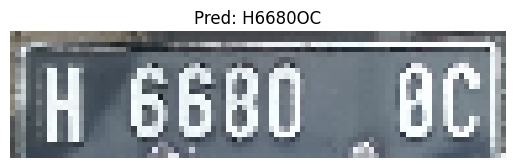

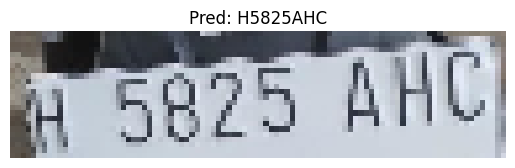

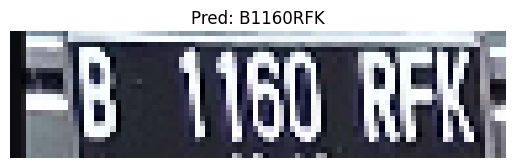

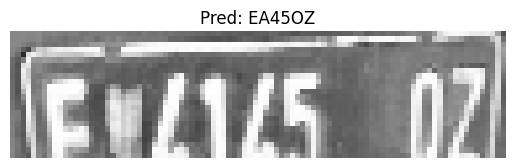

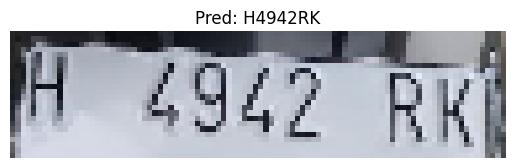

In [54]:
def show_results(model, dataset, num=5):
    model.eval()
    encoder = LPRLabelEncoder(CHARS)
    
    indices = np.random.randint(0, len(dataset), num)
    
    for idx in indices:
        img_tensor, _, _ = dataset[idx]
        input_img = img_tensor.unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = model(input_img)
            pred_text = encoder.decode_greedy(logits)[0]
            
        # De-normalize for plotting
        display_img = img_tensor.numpy().transpose(1, 2, 0)
        display_img = (display_img / 0.0078125) + 127.5
        display_img = display_img.astype(np.uint8)
        
        plt.figure()
        plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Pred: {pred_text}")
        plt.axis('off')
        plt.show()

show_results(model, val_dataset)